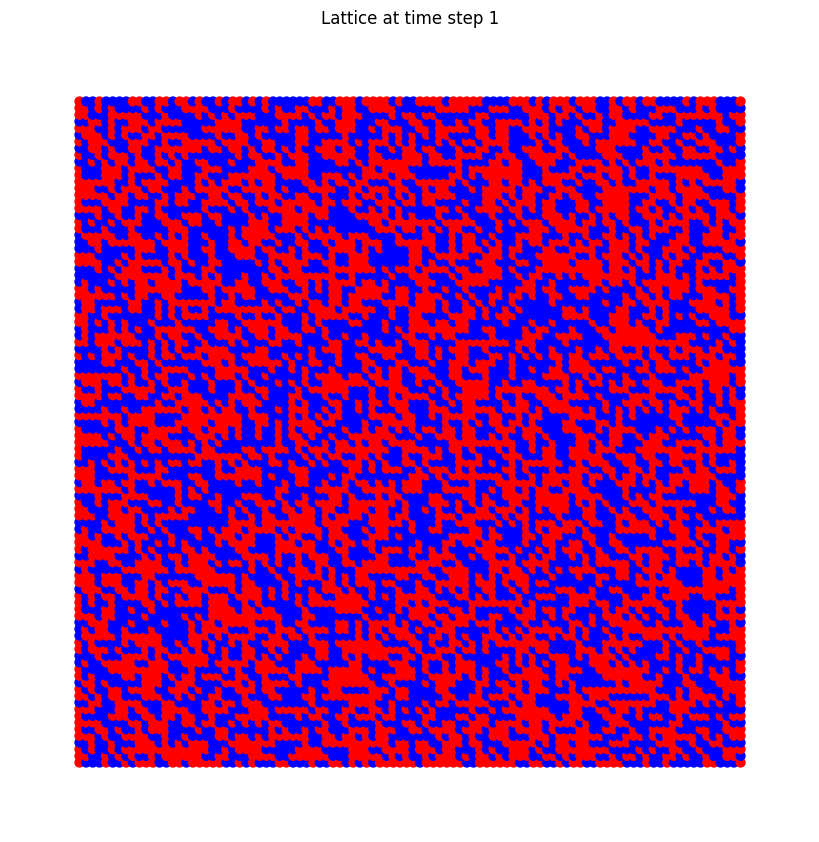

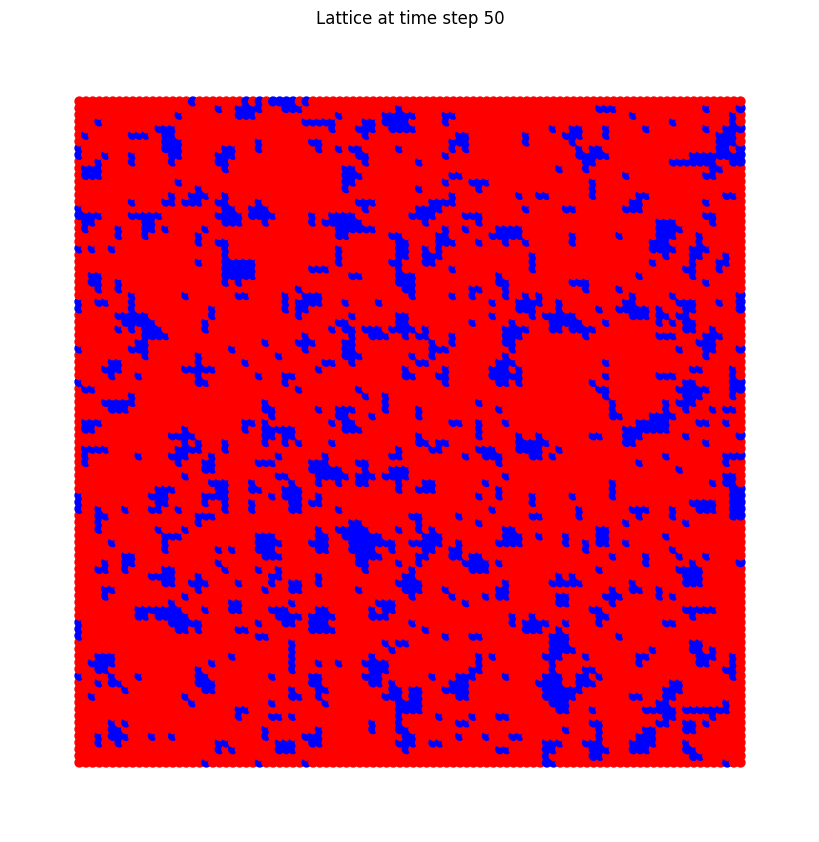

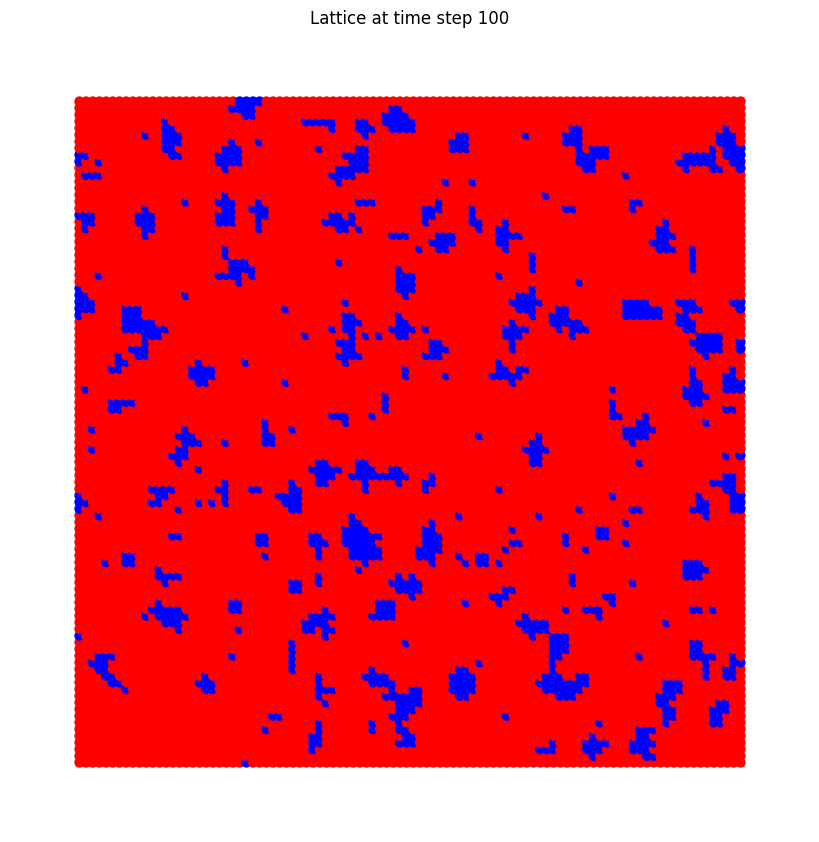

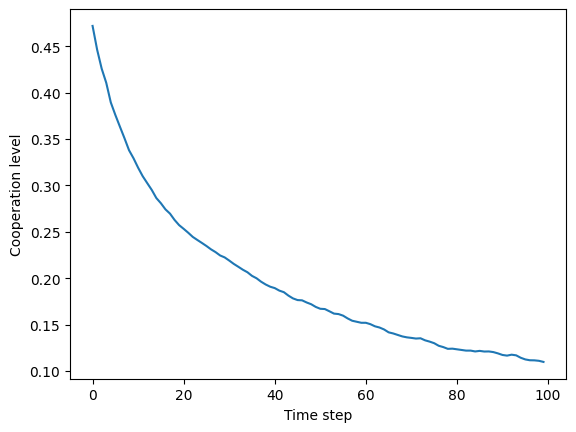

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx

# Adjust grid size to 100x100
GRID_SIZE = 100  # 100x100 lattice
NUM_AGENTS = GRID_SIZE * GRID_SIZE  # Total number of agents = 100^2 = 10,000
RICH_SITE_PROB = 0.2  # Fraction of rich sites
INITIAL_COOPERATION_PROB = 0.5
INEQUALITY_LEVEL = 10  # Resource contrast (c) between rich and poor sites
TEMPTATION_LEVEL = 0.7  # High temptation (b-1)

# Payoff matrix parameters
RICH_RESOURCE = 1 + INEQUALITY_LEVEL
POOR_RESOURCE = 1
b = 2 / TEMPTATION_LEVEL  # Public goods multiplier

# Create a 2D grid of agents (lattice)
def create_lattice():
    G = nx.grid_2d_graph(GRID_SIZE, GRID_SIZE, periodic=True)  # 2D grid with periodic boundary
    assign_resources(G)
    initialize_strategies(G, INITIAL_COOPERATION_PROB)
    return G

# Assign resources to rich and poor sites
def assign_resources(G):
    for node in G.nodes():
        if random.random() < RICH_SITE_PROB:
            G.nodes[node]['resource'] = RICH_RESOURCE
            G.nodes[node]['site_type'] = 'rich'
        else:
            G.nodes[node]['resource'] = POOR_RESOURCE
            G.nodes[node]['site_type'] = 'poor'

# Initialize strategies for agents (either cooperate 'C' or defect 'D')
def initialize_strategies(G, cooperation_prob):
    for node in G.nodes():
        G.nodes[node]['strategy'] = 'C' if random.random() < cooperation_prob else 'D'

# Play the game for one time step and calculate payoffs
def play_game(G):
    payoffs = {}
    for node in G.nodes():
        strategy = G.nodes[node]['strategy']
        resource = G.nodes[node]['resource']
        payoff = 0
        neighbors = G.neighbors(node)
        
        for neighbor in neighbors:
            neighbor_strategy = G.nodes[neighbor]['strategy']
            neighbor_resource = G.nodes[neighbor]['resource']

            # Payoff matrix from the paper (rich and poor site interactions)
            if strategy == 'C' and neighbor_strategy == 'C':
                payoff += neighbor_resource  # Cooperation between cooperators
            elif strategy == 'C' and neighbor_strategy == 'D':
                payoff += 0  # Cooperator interacting with defector
            elif strategy == 'D' and neighbor_strategy == 'C':
                payoff += b * resource  # Defector interacting with cooperator
            elif strategy == 'D' and neighbor_strategy == 'D':
                payoff += 0  # Defector interacting with defector

        payoffs[node] = payoff
    return payoffs

# Update strategies based on payoffs and stochastic imitation
def update_strategies(G, payoffs):
    new_strategies = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            neighbor = random.choice(neighbors)
            if payoffs[neighbor] > payoffs[node]:
                prob = (payoffs[neighbor] - payoffs[node]) / (max(payoffs.values()) - min(payoffs.values()) + 1e-6)
                if random.random() < prob:
                    new_strategies[node] = G.nodes[neighbor]['strategy']
                else:
                    new_strategies[node] = G.nodes[node]['strategy']
            else:
                new_strategies[node] = G.nodes[node]['strategy']
    for node in G.nodes():
        G.nodes[node]['strategy'] = new_strategies[node]

# Simulation loop
def simulate():
    G = create_lattice()
    cooperation_levels = []

    for t in range(100):  # Simulate for 100 time steps
        payoffs = play_game(G)
        update_strategies(G, payoffs)
        
        num_cooperators = sum(1 for node in G.nodes() if G.nodes[node]['strategy'] == 'C')
        cooperation_level = num_cooperators / NUM_AGENTS
        cooperation_levels.append(cooperation_level)
        
        # Plot the lattice at time steps 1, 50, and 100
        if t in [0, 49, 99]:
            plot_lattice(G, t+1)
    
    return cooperation_levels, G

# Visualization of the lattice with different colors for cooperators and defectors
def plot_lattice(G, timestep):
    # Color cooperators (blue) and defectors (red)
    strategy_map = {'C': 'blue', 'D': 'red'}
    node_colors = [strategy_map[G.nodes[node]['strategy']] for node in G.nodes()]
    
    # Draw the grid with proper node colors
    pos = dict((n, n) for n in G.nodes())  # Use grid positions
    plt.figure(figsize=(8, 8))
    
    # Increase node size to remove white spaces between dots
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=40, edge_color='black', width=0.05)
    
    plt.title(f"Lattice at time step {timestep}")
    plt.show()

# Run the simulation and plot the final state
cooperation_levels, G = simulate()

# Plot the cooperation level over time
plt.plot(cooperation_levels)
plt.xlabel("Time step")
plt.ylabel("Cooperation level")
plt.show()
